In [1]:
# results directories:
# /home/jxm3/random/interpretable-autoprompting/results/intermediate_results_from_chandan/anli
# /home/jxm3/random/interpretable-autoprompting/results/intermediate_results_from_chandan/math

%load_ext autoreload
%autoreload 2

In [2]:
import analyze_utils

In [11]:
dir_single_query = '/home/jxm3/random/interpretable-autoprompting/results/intermediate_results_from_chandan_3/math'
r = analyze_utils.load_results_and_cache_prefix_json(dir_single_query, save_file='r.pkl')

r['use_single_query'] = r['single_query']
r = analyze_utils.postprocess_results(r)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 282.32it/s]


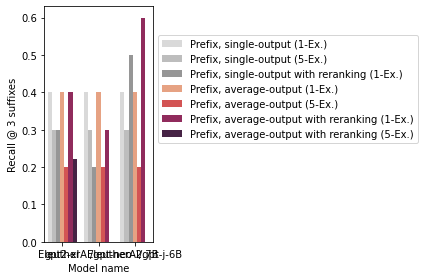

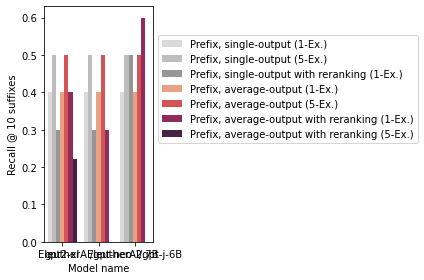

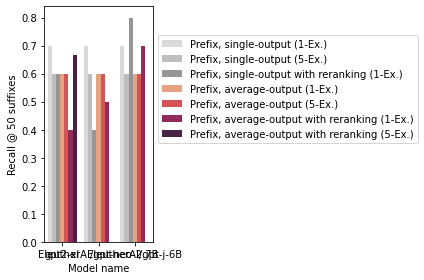

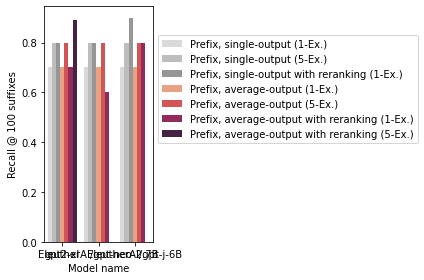

In [12]:
from typing import Dict

# rt = r[r.task_name.isin(['add_two', 'multiply_two', 'subtract_two'])]
import matplotlib.pyplot as plt
rt = r

def make_legend__prefix(table_row: Dict) -> str:
    single_query_str = {
        0: 'average',
        1: 'single'
    }[table_row['single_query']]
    rerank_str = {
        0: '',
        1: ' with reranking'
    }[table_row['do_reranking']]
    
    return 'Prefix, ' + single_query_str + '-output' + rerank_str + f' ({table_row["n_shots"]}-Ex.)'


for metric_key in [#'final_answer_pos_initial_token',
                   f'Recall @ {3} suffixes',
                   f'Recall @ {10} suffixes', 
                   f'Recall @ {50} suffixes', 
                   f'Recall @ {100} suffixes', 
                   ]:
    table = (rt
        # mean over templates, task_name)
        .groupby(['checkpoint', 'n_shots', 'do_reranking', 'single_query'])[[metric_key]]
        .mean()
        .reset_index()
    ).fillna(10_000)
    table['legend'] = table.apply(make_legend__prefix, axis=1)
    analyze_utils.plot_tab(table, metric_key=metric_key, title='Math datasets', add_legend=False)

    # if metric_key == 'final_answer_pos_initial_token':
      # plt.savefig('../results/prompt_gen/math_barplot.pdf', bbox_inches='tight')
    plt.show()


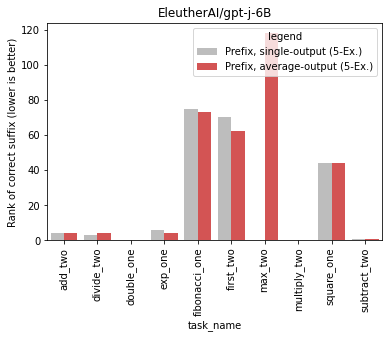

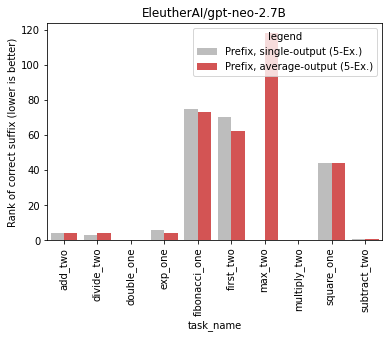

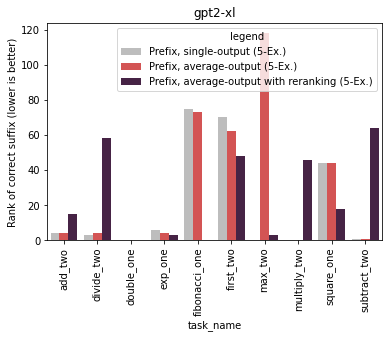

In [13]:
# cols_to_view = r_single_query.columns # cols_to_view
import pandas as pd
import seaborn as sns

key_vars = ['checkpoint', 'n_shots', 'single_query', 'do_reranking', 'task_name']
cols_to_view = [col for col in r.columns if (col.startswith('final') or 'Recall' in col)]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    rg = r.groupby(key_vars)[cols_to_view].mean().round(2)
    # display(rg[rg['final_answer_found'] < 1.0])
    # display(rg)
# r.groupby(['template_num_init_string', 'use_single_query']).median().round(2)['final_model_queries'] # look at templates

for checkpoint in rg.reset_index().checkpoint.unique():
    rp = rg.reset_index()
    # checkpoint = 'EleutherAI/gpt-j-6B'
    metric_key = 'final_answer_pos_initial_token'
    # metric_key = f'Recall @ {3} suffixes'

    rp = rp[(rp['checkpoint'] == checkpoint) & (rp['n_shots'] == 5)]
    rp['legend'] = rp.apply(make_legend__prefix, axis=1)
    hue_order = analyze_utils.get_hue_order(rp['legend'])
    plt.title(checkpoint)
    sns.barplot(x='task_name', y=metric_key, hue_order=hue_order,
                hue='legend', data=rp, palette=analyze_utils.COLORS)  # data=tab[tab['n_shots'] == 1])
    plt.xticks(rotation='vertical')
    plt.ylabel(analyze_utils.YLABS.get(metric_key, metric_key))
    plt.show()